In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''LSTMで時系列予測を行う'''

'LSTMで時系列予測を行う'

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [4]:
# 乱数固定
SEED = 20241001
keras.utils.set_random_seed(SEED)
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [5]:
# 定数
BATCH_SIZE = 32
EPOCHS = 20

In [6]:
# データ生成
rad = np.linspace(-np.pi*10, np.pi*10, BATCH_SIZE*50)
x = np.sin(rad).reshape(-1, 1, 1)
y = np.cos(rad).reshape(-1, 1)
print(f'rad.shape: {rad.shape}, x.shape: {x.shape}, y.shape: {y.shape}')

rad.shape: (1600,), x.shape: (1600, 1, 1), y.shape: (1600, 1)


In [7]:
# データ分割
n_train = int(len(x)*0.8)
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]
print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}, x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')

x_train.shape: (1280, 1, 1), y_train.shape: (1280, 1), x_test.shape: (320, 1, 1), y_test.shape: (320, 1)


In [8]:
# ハイパーパラメータ
layers = 1 # LSTMレイヤの数
stateful = True
units = 10	# LSTMをstatefulにするかどうか(False/True)
dropout = 0	# LSTM層からの出力のドロップアウト率(0.0〜1.0)
noise_scale = 0.05	# 入力へのノイズ付与率

In [9]:
# モデル構築
inputs = keras.layers.Input(batch_shape=(BATCH_SIZE, 1, 1))
x = inputs
x = keras.layers.GaussianNoise(stddev=noise_scale)(x)
for i in range(layers):
    x = keras.layers.LSTM(units=units, stateful=stateful, return_sequences=(i < layers-1))(x)

x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(1)(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 1, 1)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (32, 1, 1)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 10)               │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 10)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# モデル内の全レイヤのreset_stetesを呼び出す
def reset_states(model):
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

In [11]:
# エポック終了毎にstatesをリセットするコールバック
callback = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: reset_states(model))

In [12]:
# 学習ループ構築
model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.LogCosh(), metrics=['mse'])

In [13]:
# 学習
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=False, callbacks=[callback])

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2278 - mse: 0.5087 - val_loss: 0.2236 - val_mse: 0.4983
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2221 - mse: 0.4945 - val_loss: 0.2179 - val_mse: 0.4843
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2165 - mse: 0.4808 - val_loss: 0.2123 - val_mse: 0.4709
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2108 - mse: 0.4674 - val_loss: 0.2070 - val_mse: 0.4584
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2052 - mse: 0.4540 - val_loss: 0.2017 - val_mse: 0.4459
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1994 - mse: 0.4405 - val_loss: 0.1954 - val_mse: 0.4310
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1935 - mse: 0.4270 - val_loss: 0.1887 - val_mse: 0.4158
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1862 - mse: 0.4100 - val_loss: 0.1808 - val_mse: 0.3973
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1791 - mse:

In [14]:
# 予測を実行
p_train = model.predict(x_train, batch_size=BATCH_SIZE)
p_test = model.predict(x_test, batch_size=BATCH_SIZE)
print(f'p_train.shape: {p_train.shape}, p_test.shape: {p_test.shape}')
mse = mean_squared_error(y_test, p_test)
print(f'mse: {mse}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
p_train.shape: (1280, 1), p_test.shape: (320, 1)
mse: 0.011376809336391269


In [15]:
# グラフ全体のサイズ
fig = plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

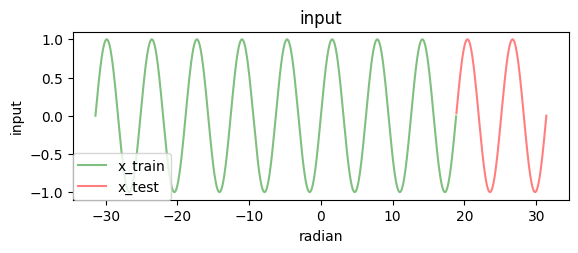

In [16]:
# 入力データx=sin(r)のグラフ(緑:訓練区間、赤:テスト区間)
plt.subplot(211)
#plt.plot(rad, x.flatten(), color='b', label='x', alpha=0.5)
plt.plot(rad[:n_train], x_train.flatten(), color='g', label='x_train', alpha=0.5)
plt.plot(rad[n_train:], x_test.flatten(), color='r', label='x_test', alpha=0.5)
plt.xlabel('radian')
plt.ylabel('input')
plt.title('input')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0)

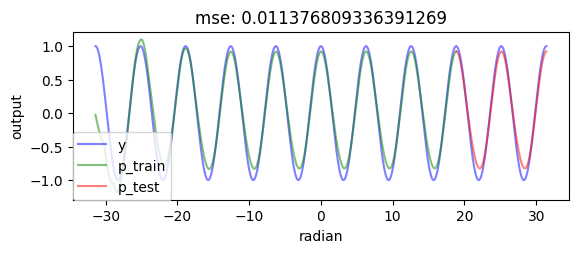

In [17]:
# 出力データy=cos(r)のグラフ(青:正解値, 緑:訓練区間予測値、赤:テスト区間予測値)
plt.subplot(212)
plt.plot(rad, y.flatten(), color='b', label='y', alpha=0.5)
plt.plot(rad[:n_train], p_train.flatten(), color='g', label='p_train', alpha=0.5)
plt.plot(rad[n_train:], p_test.flatten(), color='r', label='p_test', alpha=0.5)
plt.xlabel('radian')
plt.ylabel('output')
plt.title(f'mse: {mse}')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0)

In [18]:
# コマンドラインからの実行の場合に描画する(jupyterの場合は既に描画済みなので何も出ません)
plt.subplots_adjust(hspace=0.5)
plt.savefig('plot.png')
plt.show()

<Figure size 640x480 with 0 Axes>